# Нейронная сеть прямого распространения для задачи классификации

## Загрузка и подготовка данных

Начнем с загрузки датасата с kaggle. Необходимо использовать свой .json файл, чтобы открыть канал для загрузки, а также скопировать текст api команды. Ниже приводится стандартный код для загрузки датасета с kaggle.

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alekseimedvedev","key":"e7e2e8ad9f177293686bb5c420c22c41"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d playlist/mnistzip

 95% 55.0M/57.8M [00:00<00:00, 122MB/s]
100% 57.8M/57.8M [00:00<00:00, 113MB/s]


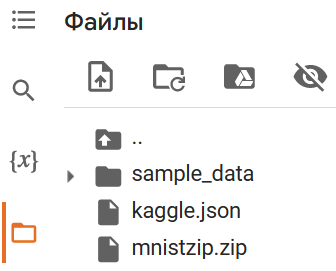

Архив скачался на внутреннюю память среды colab. Давайте его разархивируем.

In [5]:
from IPython.core.display import clear_output
!unzip '/content/mnistzip.zip' -d '/content/mnist'
clear_output()

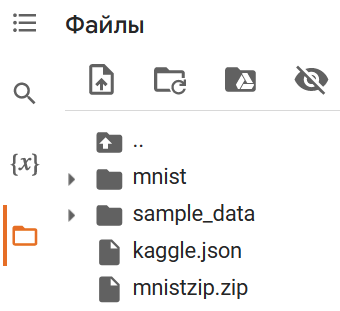

Создаем torch датасеты с помощью класса ImageFolder.

In [6]:
datadir='/content/mnist/mnist_png/mnist_png'
traindir = datadir + '/train/'
testdir = datadir + '/valid/'

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as T
from IPython.display import Image
from skimage import io
from torchvision.utils import make_grid

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cuda'

In [9]:
train_transform = T.Compose([T.Grayscale(),T.ToTensor()])
test_transform = T.Compose([T.Grayscale(),T.ToTensor()])

In [10]:
train_dataset=datasets.ImageFolder(traindir,transform=train_transform)
test_dataset=datasets.ImageFolder(testdir,transform=test_transform)

Зададим два итератора данных, которые разобьют выборки на случайные пакеты фиксированного размера.

In [11]:
batch_size=32 # размер пакета
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
dataloaders = {"train": train_loader,"validation": test_loader}

In [12]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

torch.Size([32, 1, 28, 28])


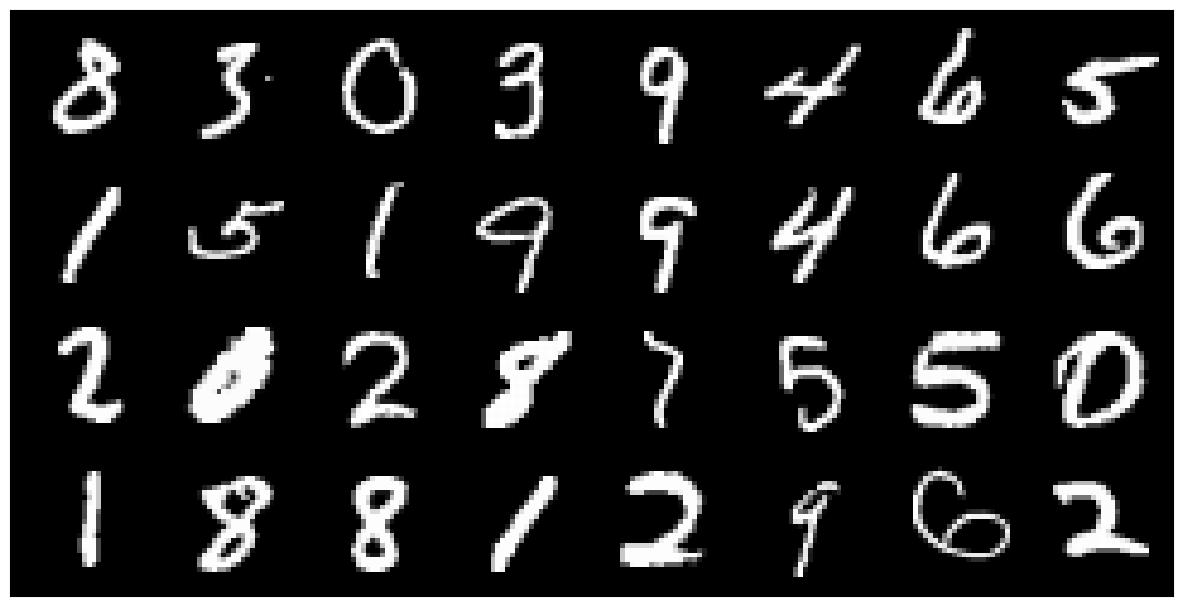

In [13]:
show_batch(dataloaders['train'])

## Задаем модель

In [14]:
import torch.nn as nn

class Simple_MNIST_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28,128)
    self.fc2 = nn.Linear(128,10)
    self.activation = nn.LeakyReLU(inplace=True)

  def forward(self,x): # прямой проход модели
    x = x.view(-1,28*28) # распрямляем изображение в вектор
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    return x

Инициализируем модель и отправляем на вычислительный процессор.

In [15]:
model=Simple_MNIST_NN()
model.to(device)

Simple_MNIST_NN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
)

Выведем подробную детализацию модели.

In [16]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from torchinfo import summary
summary(model,input_size=(1, 28, 28))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Simple_MNIST_NN                          [1, 10]                   --
├─Linear: 1-1                            [1, 128]                  100,480
├─LeakyReLU: 1-2                         [1, 128]                  --
├─Linear: 1-3                            [1, 10]                   1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

## Цикл обучения модели.

Создаем цикл обучения модели.

In [18]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Для подсчета метрик, вывода графиков, матрицы ошибок, будем использовать высокоуровневую библиотеку **ignite**

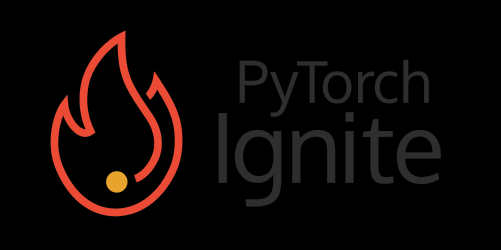

In [19]:
!pip install pytorch-ignite --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 KB 8.6 MB/s eta 0:00:00


In [20]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

Задаем движок обучения.

In [21]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [22]:
metrics = { "loss" : Loss(criterion), 
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=10)}

Задаем вычисление метрик.

In [23]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [24]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

Добавляем вычисление и запись метрик по событию - конец эпохи.

In [25]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [26]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

Используем раннюю остановку: если 10 эпох подряд точность на валидационной выборке не увеличивалась, то прекращаем обучение.

In [27]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

Сохраняем 2 лучшие по точности модели.

In [28]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=2, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

Добавим вывод шкалы прогресса (есть два режима: блокнот и консоль)

In [29]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

/usr/local/lib/python3.9/dist-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


В конце обучения выведем матрицу ошибок.

In [30]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = train_dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

## Запуск обучения модели

  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 95.98 Сред. ошибка: 0.14048
Результат валидации - Эпоха: 1  Сред. точность: 95.85 Сред. ошибка: 0.14270


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 97.69 Сред. ошибка: 0.08210
Результат валидации - Эпоха: 2  Сред. точность: 97.06 Сред. ошибка: 0.09696


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 98.35 Сред. ошибка: 0.05652
Результат валидации - Эпоха: 3  Сред. точность: 97.56 Сред. ошибка: 0.08054


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 98.80 Сред. ошибка: 0.04156
Результат валидации - Эпоха: 4  Сред. точность: 97.69 Сред. ошибка: 0.07693


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 98.83 Сред. ошибка: 0.03939
Результат валидации - Эпоха: 5  Сред. точность: 97.40 Сред. ошибка: 0.08572


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 99.22 Сред. ошибка: 0.02733
Результат валидации - Эпоха: 6  Сред. точность: 97.81 Сред. ошибка: 0.07551


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 99.45 Сред. ошибка: 0.02000
Результат валидации - Эпоха: 7  Сред. точность: 97.62 Сред. ошибка: 0.07706


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 99.44 Сред. ошибка: 0.01915
Результат валидации - Эпоха: 8  Сред. точность: 97.72 Сред. ошибка: 0.07721


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 99.58 Сред. ошибка: 0.01495
Результат валидации - Эпоха: 9  Сред. точность: 97.74 Сред. ошибка: 0.07768


  0%|          | 1/1875 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 99.55 Сред. ошибка: 0.01492
Результат валидации - Эпоха: 10  Сред. точность: 97.78 Сред. ошибка: 0.08359


State:
	iteration: 18750
	epoch: 10
	epoch_length: 1875
	max_epochs: 10
	output: 0.006791236810386181
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

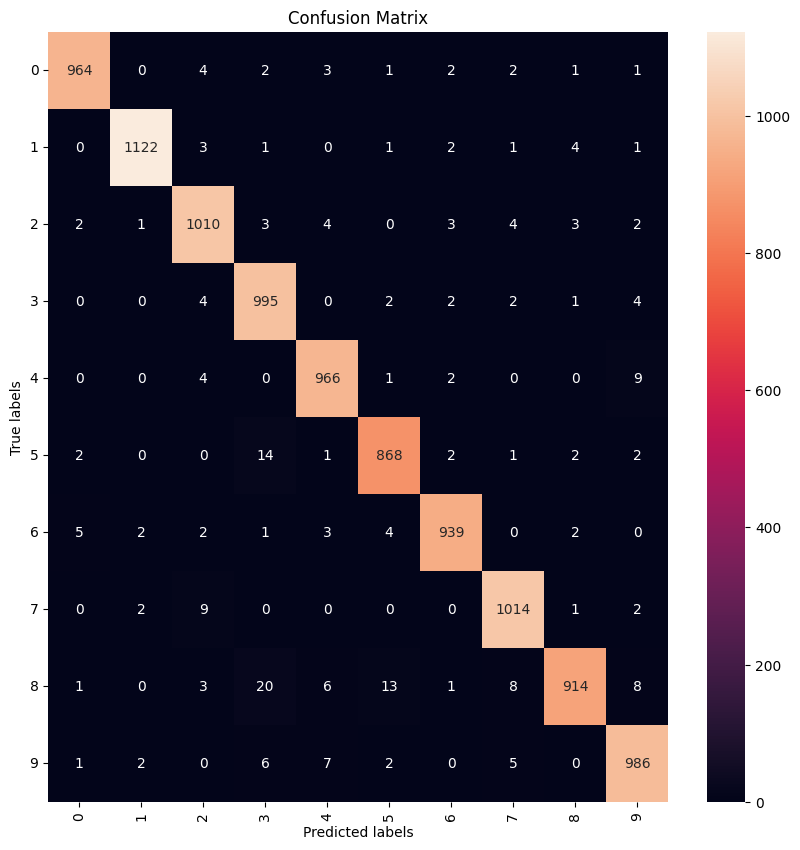

In [31]:
trainer.run(train_loader, max_epochs=10)

## Анализ обученной модели.

Кривые обучения и валидации.

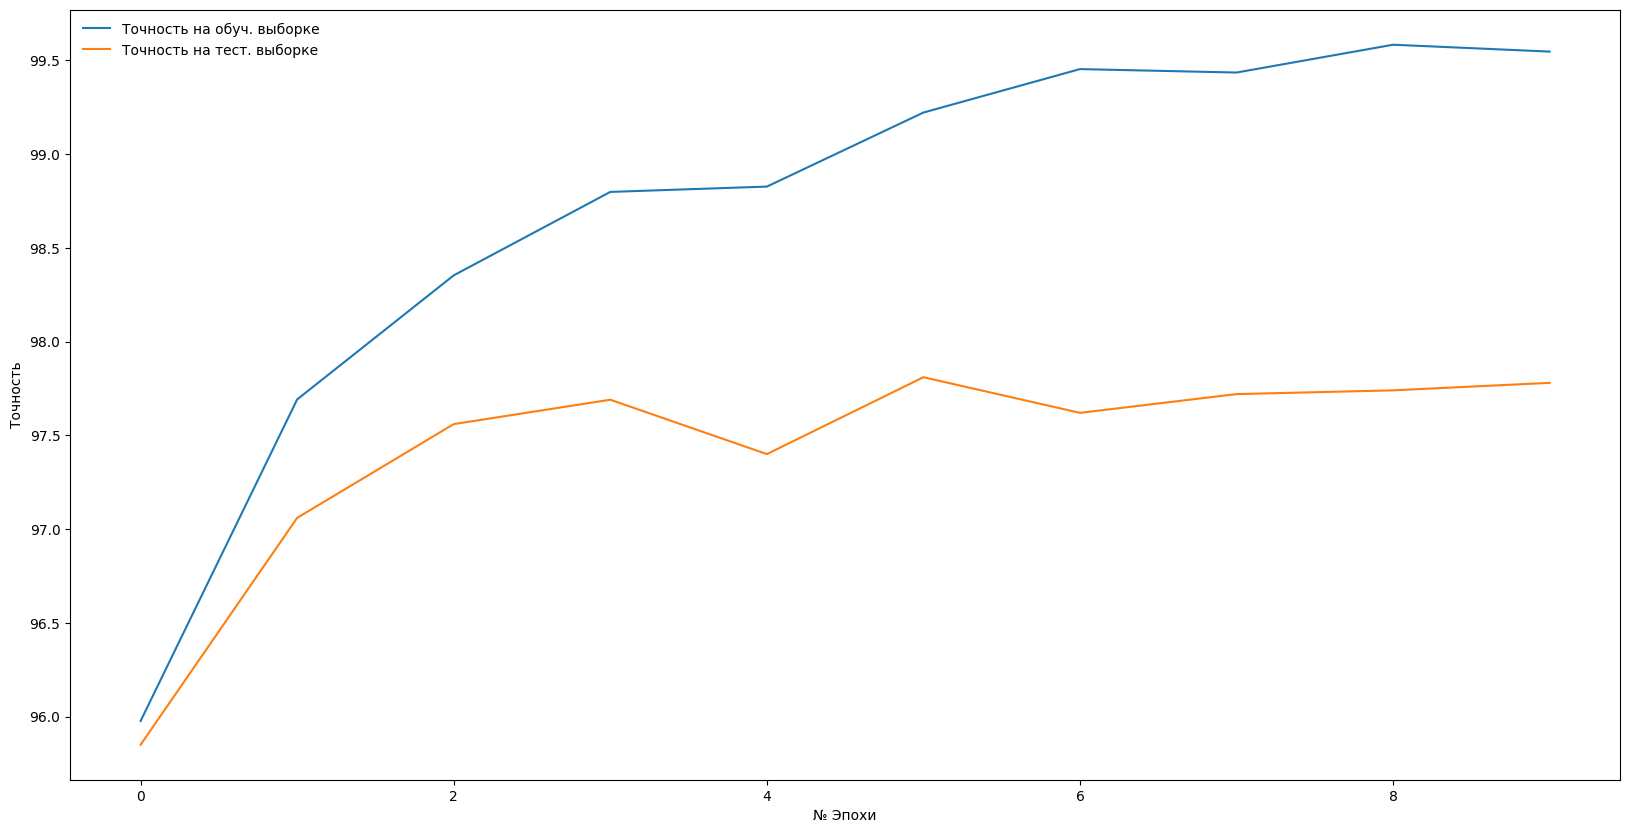

In [32]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['accuracy'],label="Точность на обуч. выборке")
plt.plot(test_history['accuracy'],label="Точность на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Точность')
plt.legend(frameon=False)
plt.show()

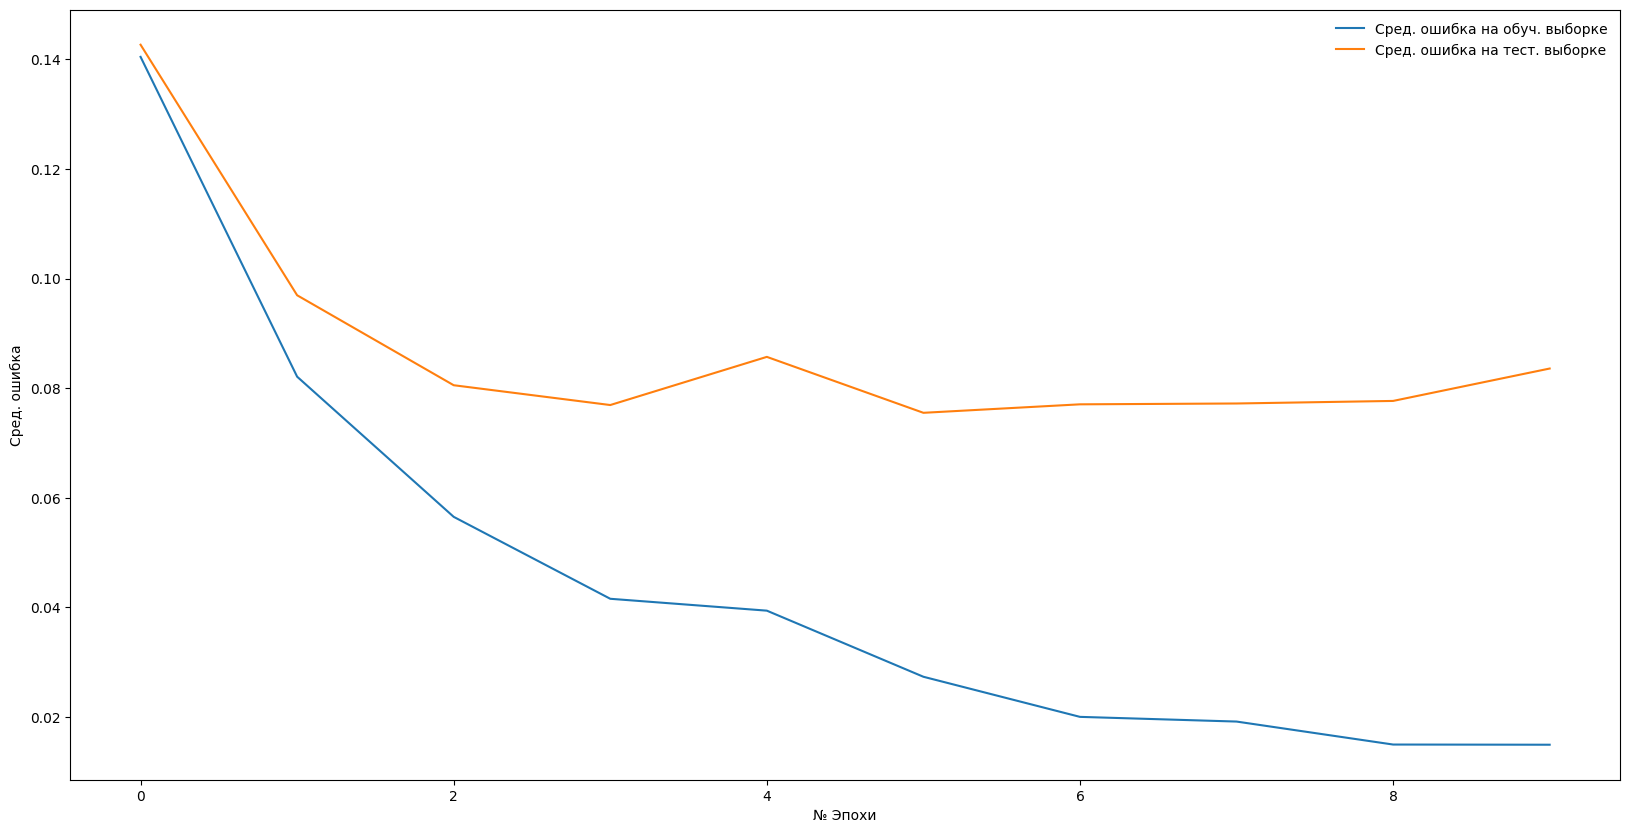

In [33]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['loss'],label="Сред. ошибка на обуч. выборке")
plt.plot(test_history['loss'],label="Сред. ошибка на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Сред. ошибка')
plt.legend(frameon=False)
plt.show()

Посмотрим на примеры, которые были неправильно предсказаны.

In [34]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))
print("Модель загружена")

Модель загружена


In [35]:
loader = DataLoader(test_dataset, batch_size=10000, shuffle=True)

In [36]:
dataiter = iter(loader)
images, labels = next(dataiter)
images_arr = []
labels_arr = []
pred_arr = []
model.to("cpu")
for i in range(0,10000):
    images_arr.append(images[i].unsqueeze(0))
    labels_arr.append(labels[i].item())
    ps = torch.exp(model(images_arr[i]))
    ps = ps.data.numpy().squeeze()
    pred_arr.append(np.argmax(ps))

In [37]:
misclass=[]
for i in range(len(labels_arr)-1):
    if labels_arr[i]!=pred_arr[i]:
        misclass.append(i)

In [38]:
len(misclass)

222

In [39]:
classes=train_dataset.classes

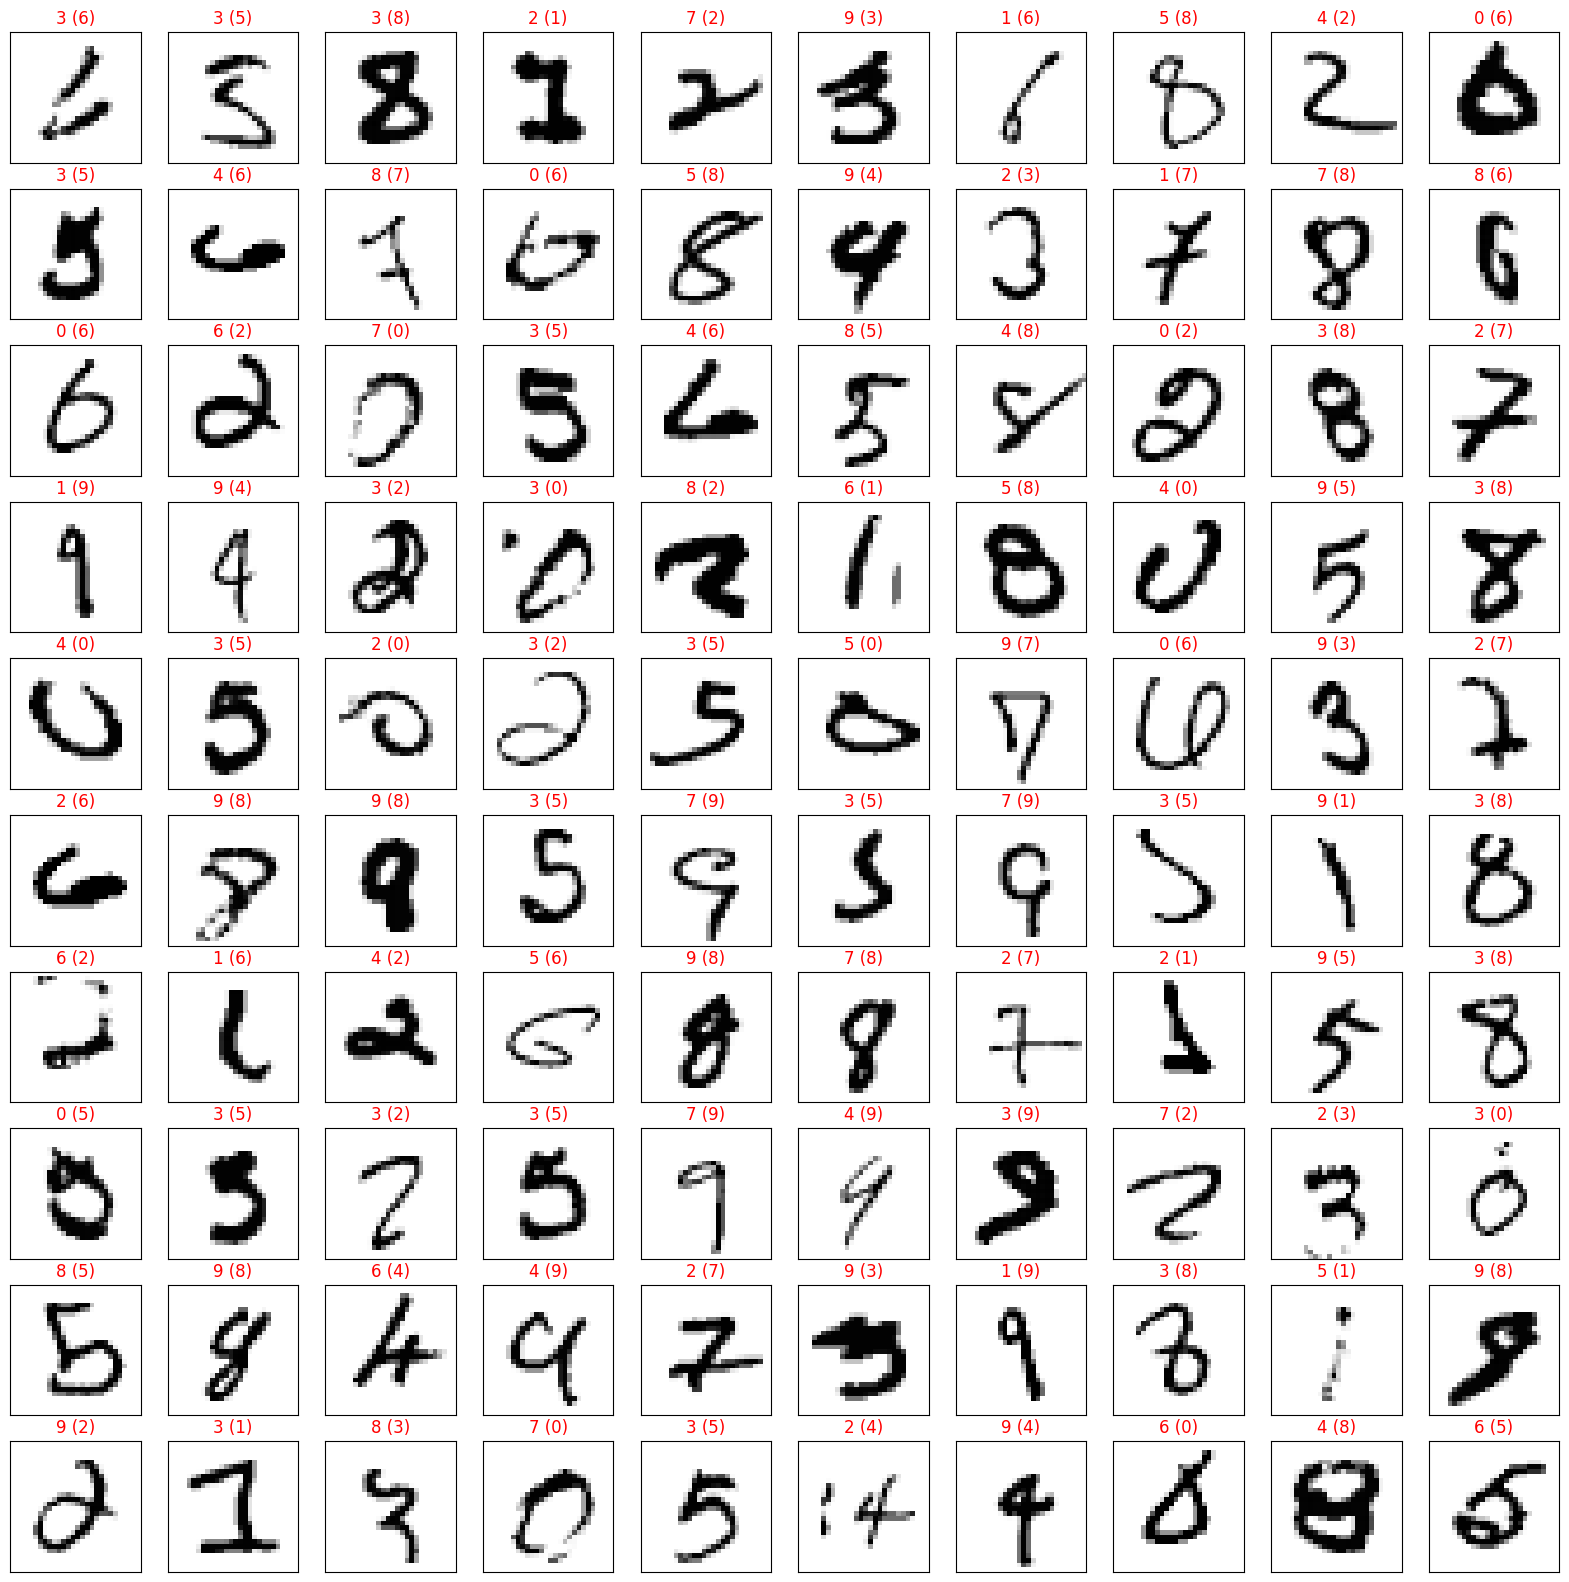

In [40]:
fig = plt.figure(figsize=(20,20))
for i in range(100):
    ind=misclass[i]
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(images_arr[ind].view(-1,28,28).to('cpu').numpy().squeeze(),cmap='Greys')
    ax.set_title("{} ({})".format(classes[pred_arr[ind]], classes[labels_arr[ind]]),
                 color=("green" if pred_arr[ind]==labels_arr[ind] else "red"))